In [1]:
!pip install evaluate
!pip install rouge_score



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu

In [66]:
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
import numpy as np
from transformers import (
    ViTModel, 
    GPT2LMHeadModel, 
    GPT2Tokenizer, 
    ViTImageProcessor, 
    pipeline,
    AutoProcessor, 
    AutoModelForCausalLM,
    GPT2Config,
ViTFeatureExtractor,
AutoModelForVision2Seq
)
import torch.nn.functional as F


In [12]:
## ================== PART B: OCCLUSION ANALYSIS ================== ##

### 1. Image Occlusion Implementation
def occlude_image(image_tensor, occlusion_level=0.1):
    """
    Applies random patch occlusion to an image tensor (ViT-compatible 16x16 patches)
    
    Args:
        image_tensor (torch.Tensor): [C, H, W] tensor
        occlusion_level (float): 0-1 percentage of patches to occlude
        
    Returns:
        torch.Tensor: Occluded image tensor
    """
    C, H, W = image_tensor.shape
    patch_size = 16
    
    # Create patch grid
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w
    
    # Create mask
    num_occluded = int(num_patches * occlusion_level)
    patch_indices = torch.randperm(num_patches)[:num_occluded]
    
    # Reshape into patches
    patches = image_tensor.unfold(1, patch_size, patch_size)\
                         .unfold(2, patch_size, patch_size)\
                         .contiguous()\
                         .view(C, -1, patch_size, patch_size)
    
    # Apply occlusion (set to black)
    for idx in patch_indices:
        patches[:, idx] = 0
    
    # Reconstruct image
    occluded_image = patches.view(C, num_patches_h, num_patches_w, patch_size, patch_size)
    occluded_image = occluded_image.permute(0, 1, 3, 2, 4)\
                                  .contiguous()\
                                  .view(C, H, W)
    return occluded_image



In [64]:
### 2. Modified Evaluation Function
def evaluate_on_occluded_images(model, dataloader, device, occlusion_levels=[0.0], model_type="custom"):
    """
    Evaluates model performance at different occlusion levels
    Saves results for Part C in '<original> <SEP> <generated> <SEP> <perturbation>' format
    """
    results = {}
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2") if model_type=="custom" else None
    if tokenizer:
        tokenizer.pad_token = tokenizer.eos_token
    
    # # Load evaluation metrics
    # bleu = evaluate.load("bleu")
    # rouge = evaluate.load("rouge")
    # meteor = evaluate.load("meteor")
    
    for level in occlusion_levels:
        print(f"\nEvaluating at {level*100:.0f}% occlusion...")
        
        predictions = []
        references = []
        filenames = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Processing {level*100:.0f}% occlusion"):
                # Handle different batch formats
                #images, _, _, captions, paths = batch
                images = batch['image']
                captions=batch['caption']
                paths=batch['filename']
                
                # Apply occlusion
                occluded_images = torch.stack([
                    occlude_image(img, level) for img in images
                ]).to(device)
                
                # Generate captions
                if model_type == "custom":
                    batch_size = occluded_images.shape[0]
                    
                    # Initialize input_ids with BOS token
                    input_ids = torch.full(
                        (batch_size, 1),
                        tokenizer.bos_token_id,
                        dtype=torch.long,
                        device=device
                    )
                    
                    max_length = 128  # Define maximum caption length
                    generated_captions = []
                    
                    for _ in range(max_length):
                        # Forward pass through the model
                        logits = model(occluded_images, input_ids)
                        
                        # Get next token logits and select the most probable token
                        next_token_logits = logits[:, -1, :]
                        next_tokens = torch.argmax(next_token_logits, dim=-1)
                        
                        # Append the predicted token to input_ids
                        input_ids = torch.cat([input_ids, next_tokens.unsqueeze(1)], dim=1)
                        
                        # Stop if all sequences have reached EOS token
                        if torch.all(next_tokens == tokenizer.eos_token_id):
                            break
                    
                    # Decode generated tokens into text captions
                    for ids in input_ids:
                        generated_captions.append(tokenizer.decode(ids, skip_special_tokens=True))
                    
                    predictions.extend(generated_captions)
                    # generated = model.generate(occluded_images, tokenizer)
                else:  # SmolVLM
                    generated = []
                    for i, img in enumerate(occluded_images):
                        # Save occluded image temporarily
                        temp_path = f"/tmp/occluded_{i}_{level}.jpg"
                        transforms.ToPILImage()(img.cpu()).save(temp_path)
                        generated.append(zero_shot_captioning(temp_path))
                
                    predictions.extend(generated)
                references.extend(captions)
                filenames.extend(paths)
        
        # Calculate metrics
        bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
        rouge_score = rouge.compute(predictions=predictions, references=references)
        meteor_score = meteor.compute(predictions=predictions, references=references)
        
        results[level] = {
            "bleu": bleu_score["bleu"],
            "rouge_l": rouge_score["rougeL"],
            "meteor": meteor_score["meteor"]
        }
        
        # Save for Part C
        save_perturbation_data(filenames, predictions, references, level, model_type)
    
    return results



In [11]:
# Ensure device compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
### 3. Data Saving for Part C
def save_perturbation_data(filenames, predictions, references, occlusion_level, model_name):
    """Saves data in required format for classifier training"""
    data = []
    for path, pred, ref in zip(filenames, predictions, references):
        data.append({
            "original": ref,
            "generated": pred,
            "perturbation": occlusion_level,
            "model": model_name,
            "image_path": path
        })
    
    df = pd.DataFrame(data)
    
    # Create output directory if it doesn't exist
    os.makedirs("perturbation_data", exist_ok=True)
    
    # Save to CSV
    output_file = f"perturbation_data/perturbation_data_{model_name}_{occlusion_level}.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved perturbation data to {output_file}")



In [15]:
### 4. Visualization Function
def visualize_occlusion(image_tensor, occlusion_levels=[0.0, 0.1, 0.5, 0.8]):
    """Visualize the effect of different occlusion levels on an image"""
    fig, axes = plt.subplots(1, len(occlusion_levels), figsize=(15, 3))
    
    for i, level in enumerate(occlusion_levels):
        if level == 0.0:
            img = image_tensor
        else:
            img = occlude_image(image_tensor, level)
            
        # Convert tensor to PIL image for display
        img_pil = transforms.ToPILImage()(img)
        axes[i].imshow(img_pil)
        axes[i].set_title(f"{int(level*100)}% Occlusion")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



In [20]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data_path, image_folder, transform=None, max_length=128):
        """
        Args:
            data_path (str): Path to the CSV file with annotations
            image_folder (str): Directory with all the images
            transform (callable, optional): Optional transform to be applied on an image
            max_length (int): Maximum length of the caption
        """
        self.data = pd.read_csv(data_path)
        self.image_folder = image_folder
        self.transform = transform
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx]['filename']  # Get filename from CSV
        img_name = os.path.join(self.image_folder, filename)
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.data.iloc[idx]['caption']  # Using 'caption' column

        # Tokenize caption
        caption_encoding = self.tokenizer(
            caption,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'input_ids': caption_encoding['input_ids'].squeeze(),
            'attention_mask': caption_encoding['attention_mask'].squeeze(),
            'caption': caption,
            'filename': filename
        }



In [ ]:
from transformers import ViTModel


class ImageCaptionModel(nn.Module):
    def __init__(self, vit_model_name='google/vit-base-patch16-224-in21k', gpt_model_name='gpt2', projection_dim=768):
        """
        Custom Encoder-Decoder Model for Image Captioning using ViT as an encoder

        Args:
            vit_model_name (str): Name of the ViT model to use as encoder
            gpt_model_name (str): Name of the GPT model to use as decoder
            projection_dim (int): Dimension of the projection layer
        """
        super(ImageCaptionModel, self).__init__()

        # Load pre-trained ViT model as the encoder (using ViT-Small as specified in assignment)
        self.encoder = ViTModel.from_pretrained(vit_model_name, token = "xxx")
        encoder_dim = self.encoder.config.hidden_size

        # Load pre-trained GPT-2 model as the decoder
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt_model_name)
        decoder_dim = self.decoder.config.n_embd

        # Projection layer to map encoder features to decoder dimension
        self.projection = nn.Linear(encoder_dim, projection_dim)

        # Cross-attention layers for decoder to attend to image features
        self.cross_attn = nn.MultiheadAttention(projection_dim, num_heads=8, batch_first=True)

        # Map projected image features to decoder dimension for conditioning
        self.img_to_decoder_dim = nn.Linear(projection_dim, decoder_dim)

        # Freeze some of the encoder layers to prevent overfitting and reduce memory usage
        for param in list(self.encoder.parameters())[:6]:
            param.requires_grad = False

    def forward(self, pixel_values, input_ids, attention_mask=None):
        """
        Forward pass of the model

        Args:
            pixel_values (torch.Tensor): Batch of images
            input_ids (torch.Tensor): Tokenized captions
            attention_mask (torch.Tensor, optional): Attention mask for captions

        Returns:
            torch.Tensor: Logits for predicting the next token
        """
        # Encode the image
        encoder_outputs = self.encoder(pixel_values)
        image_features = encoder_outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # Project image features to the common dimension
        projected_features = self.projection(image_features)

        # Process through GPT-2
        # First, conditioning with image features
        img_features_decoder_dim = self.img_to_decoder_dim(projected_features[:, 0].unsqueeze(1))

        # Get embeddings from GPT-2
        decoder_outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )

        # Get hidden states from the last layer
        hidden_states = decoder_outputs.hidden_states[-1]

        # Project hidden states to the common dimension for cross-attention
        projected_hidden_states = F.linear(hidden_states, self.projection.weight.t())

        # Apply cross-attention between text features and image features
        cross_attended, _ = self.cross_attn(projected_hidden_states, projected_features, projected_features)

        # Combine with original hidden states (add residuals)
        final_hidden_states = hidden_states + cross_attended

        # Project to vocabulary through decoder's language modeling head
        lm_logits = self.decoder.lm_head(final_hidden_states)

        return lm_logits

In [22]:
def zero_shot_captioning(image_path, model_name="smolvlm"):
    try:
        if model_name == "smolvlm":
            processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
            model = AutoModelForVision2Seq.from_pretrained(
                "HuggingFaceTB/SmolVLM-500M-Instruct",
                torch_dtype=torch.float16,
                _attn_implementation="eager"
            ).to("cuda" if torch.cuda.is_available() else "cpu")

            # 1. Prepare image and messages with proper structure
            image = Image.open(image_path).convert("RGB").resize((384, 384))
            messages = [{
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Describe this image:"}
                ]
            }]

            # 2. Apply chat template
            prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

            # 3. Process with both image and formatted prompt
            inputs = processor(
                text=prompt,
                images=image,
                return_tensors="pt"
            ).to(model.device)

            # 4. Generate with proper parameters
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=False
            )

            caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            return caption

        else:
            raise ValueError(f"Model {model_name} not supported.")

    except Exception as e:
        print(f"Error: {e}")
        return "Error generating caption"


In [62]:
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
    
# Load models
custom_model = ImageCaptionModel().to(device)
custom_model.load_state_dict(torch.load("/kaggle/input/model-ritam/image_caption_model_final.pth", map_location=device))
custom_model.eval()
                    


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipykernel_31/513468824.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

ImageCaptionModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate

In [54]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [55]:
test_csv = "/kaggle/input/dl-dataset-ass2/custom_captions_dataset/test.csv"
test_images = "/kaggle/input/dl-dataset-ass2/custom_captions_dataset/test"


full_dataset = ImageCaptionDataset(test_csv, test_images, transform)
# subset_indices = list(range(100))  # Use first 100 samples
# test_dataset = Subset(full_dataset, subset_indices)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
    

test_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)

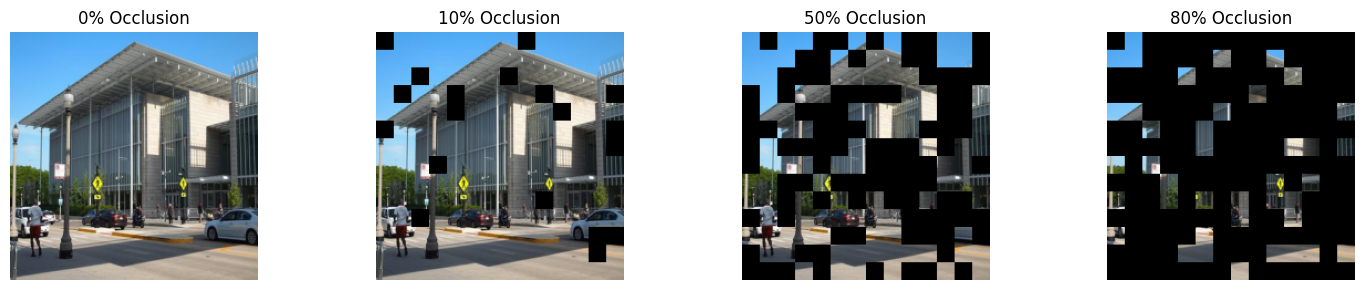

In [58]:
from PIL import Image

# 1. Load the image properly
sample_image_path = "/kaggle/input/dl-dataset-ass2/custom_captions_dataset/test/test_1.jpg"
pil_image = Image.open(sample_image_path).convert('RGB') 

# 2. Apply transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_tensor = transform(pil_image)  # Now a valid tensor

# 3. Visualize
visualize_occlusion(image_tensor)


In [56]:
# Evaluate both models at different occlusion levels
occlusion_levels = [0, 0.1, 0.5, 0.8]

In [67]:
print("\n" + "="*50)
print("Evaluating Custom Model...")
custom_results = evaluate_on_occluded_images(
    custom_model, test_loader, device, occlusion_levels, "custom"
)




Evaluating Custom Model...

Evaluating at 0% occlusion...


Processing 0% occlusion: 100%|██████████| 58/58 [37:19<00:00, 38.62s/it]


Saved perturbation data to perturbation_data/perturbation_data_custom_0.csv

Evaluating at 10% occlusion...


Processing 10% occlusion: 100%|██████████| 58/58 [37:17<00:00, 38.58s/it]


Saved perturbation data to perturbation_data/perturbation_data_custom_0.1.csv

Evaluating at 50% occlusion...


Processing 50% occlusion: 100%|██████████| 58/58 [37:18<00:00, 38.59s/it]


Saved perturbation data to perturbation_data/perturbation_data_custom_0.5.csv

Evaluating at 80% occlusion...


Processing 80% occlusion: 100%|██████████| 58/58 [37:11<00:00, 38.48s/it]


Saved perturbation data to perturbation_data/perturbation_data_custom_0.8.csv


In [59]:
print("\n" + "="*50)
print("Evaluating SmolVLM...")
smolvlm_results = evaluate_on_occluded_images(
    None, test_loader, device, occlusion_levels, "smolvlm"
)




Evaluating SmolVLM...

Evaluating at 0% occlusion...


Processing 0% occlusion: 100%|██████████| 58/58 [1:20:51<00:00, 83.65s/it]


Saved perturbation data to perturbation_data/perturbation_data_smolvlm_0.csv

Evaluating at 10% occlusion...


Processing 10% occlusion: 100%|██████████| 58/58 [1:18:37<00:00, 81.33s/it]


Saved perturbation data to perturbation_data/perturbation_data_smolvlm_0.1.csv

Evaluating at 50% occlusion...


Processing 50% occlusion: 100%|██████████| 58/58 [1:21:18<00:00, 84.11s/it]


Saved perturbation data to perturbation_data/perturbation_data_smolvlm_0.5.csv

Evaluating at 80% occlusion...


Processing 80% occlusion: 100%|██████████| 58/58 [1:22:14<00:00, 85.08s/it]


Saved perturbation data to perturbation_data/perturbation_data_smolvlm_0.8.csv


In [68]:
# Print comparison table
print("\nPerformance Comparison:")
print(f"{'Occlusion':<10} | {'Model':<10} | {'BLEU':<6} | {'ROUGE-L':<7} | {'METEOR':<6}")
print(f"{'-'*50}")

for level in occlusion_levels:
    print(f"{level*100:<10.0f}% | {'Custom':<10} | "
          f"{custom_results[level]['bleu']:.4f} | "
          f"{custom_results[level]['rouge_l']:.4f} | "
          f"{custom_results[level]['meteor']:.4f}")





Performance Comparison:
Occlusion  | Model      | BLEU   | ROUGE-L | METEOR
--------------------------------------------------
0         % | Custom     | 0.0582 | 0.2470 | 0.2586
10        % | Custom     | 0.0585 | 0.2465 | 0.2593
50        % | Custom     | 0.0546 | 0.2432 | 0.2526
80        % | Custom     | 0.0492 | 0.2366 | 0.2391


In [61]:
# Print comparison table
print("\nPerformance Comparison:")
print(f"{'Occlusion':<10} | {'Model':<10} | {'BLEU':<6} | {'ROUGE-L':<7} | {'METEOR':<6}")
print(f"{'-'*50}")

for level in occlusion_levels:
    print(f"{level*100:<10.0f}% | {'SmolVLM':<10} | "
          f"{smolvlm_results[level]['bleu']:.4f} | "
          f"{smolvlm_results[level]['rouge_l']:.4f} | "
          f"{smolvlm_results[level]['meteor']:.4f}")


Performance Comparison:
Occlusion  | Model      | BLEU   | ROUGE-L | METEOR
--------------------------------------------------
0         % | SmolVLM    | 0.0124 | 0.1757 | 0.1497
10        % | SmolVLM    | 0.0105 | 0.1708 | 0.1431
50        % | SmolVLM    | 0.0058 | 0.1599 | 0.1349
80        % | SmolVLM    | 0.0037 | 0.1528 | 0.1263
